Import Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Check Device (GPU/CPU)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Define Image Size & Transforms

In [3]:
IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

Load & Filter Dataset (Only yes, no)

In [5]:
from torchvision.datasets import ImageFolder
from collections import Counter

# ✅ Dataset path (update if needed)
data_dir = "D:/YOLO Comparision/BrainTumor_CNN"
valid_classes = ['no', 'yes']

# ✅ Load raw dataset
raw_dataset = ImageFolder(root=data_dir, transform=transform)
original_class_to_idx = raw_dataset.class_to_idx
print("Original class mapping:", original_class_to_idx)

# ✅ Keep only 'no' and 'yes', and remap to 0 and 1
keep_ids = [original_class_to_idx[c] for c in valid_classes]
filtered_samples = [
    (path, 0 if label == original_class_to_idx['no'] else 1)
    for path, label in raw_dataset.samples
    if label in keep_ids
]

# ✅ Final dataset
raw_dataset.samples = filtered_samples
raw_dataset.targets = [label for _, label in filtered_samples]
raw_dataset.classes = ['no', 'yes']
raw_dataset.class_to_idx = {'no': 0, 'yes': 1}

# ✅ Label check
print("Filtered classes:", raw_dataset.classes)
print("Label distribution:", Counter(raw_dataset.targets))

Original class mapping: {'Br35H-Mask-RCNN': 0, 'no': 1, 'pred': 2, 'yes': 3}
Filtered classes: ['no', 'yes']
Label distribution: Counter({0: 1500, 1: 1500})


Split & Load Data

In [6]:
train_size = int(0.8 * len(raw_dataset))
val_size = len(raw_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(raw_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

Define CNN Model

In [7]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)  # For CrossEntropyLoss (2 classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = BrainTumorCNN().to(device)

Loss Function & Optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the Model

In [9]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [10]:
def train_model(epochs=10):
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

    return train_acc_list, val_acc_list

train_acc, val_acc = train_model(epochs=20)

Epoch 1: Train Acc = 74.21%, Val Acc = 83.00%
Epoch 2: Train Acc = 83.75%, Val Acc = 88.33%
Epoch 3: Train Acc = 89.67%, Val Acc = 90.67%
Epoch 4: Train Acc = 94.29%, Val Acc = 94.50%
Epoch 5: Train Acc = 96.42%, Val Acc = 95.67%
Epoch 6: Train Acc = 97.75%, Val Acc = 96.50%
Epoch 7: Train Acc = 98.42%, Val Acc = 96.33%
Epoch 8: Train Acc = 99.12%, Val Acc = 96.67%
Epoch 9: Train Acc = 98.83%, Val Acc = 96.50%
Epoch 10: Train Acc = 99.25%, Val Acc = 97.33%
Epoch 11: Train Acc = 99.42%, Val Acc = 96.83%
Epoch 12: Train Acc = 99.58%, Val Acc = 96.83%
Epoch 13: Train Acc = 99.54%, Val Acc = 96.33%
Epoch 14: Train Acc = 99.50%, Val Acc = 96.33%
Epoch 15: Train Acc = 99.71%, Val Acc = 95.83%
Epoch 16: Train Acc = 99.46%, Val Acc = 96.83%
Epoch 17: Train Acc = 99.71%, Val Acc = 95.83%
Epoch 18: Train Acc = 99.46%, Val Acc = 96.83%
Epoch 19: Train Acc = 99.50%, Val Acc = 96.83%
Epoch 20: Train Acc = 99.54%, Val Acc = 97.00%


Plot Accuracy

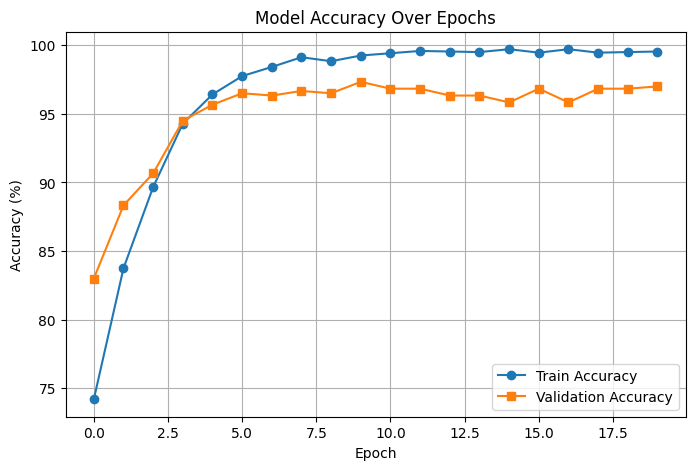

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label="Train Accuracy", marker='o')
plt.plot(val_acc, label="Validation Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

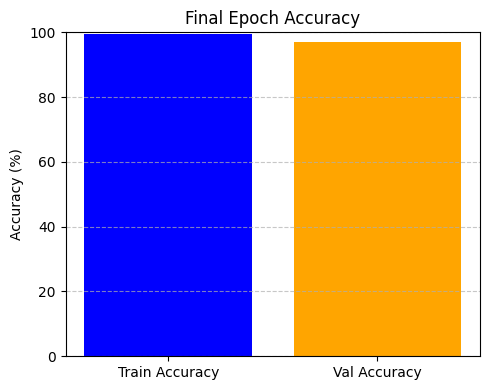

In [17]:
plt.figure(figsize=(5, 4))
plt.bar(['Train Accuracy', 'Val Accuracy'], [train_acc[-1], val_acc[-1]], color=['blue', 'orange'])
plt.title("Final Epoch Accuracy")
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

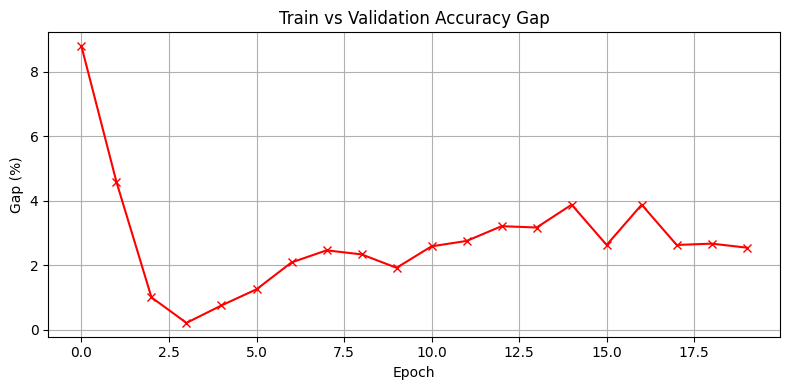

In [18]:
accuracy_gap = [abs(t - v) for t, v in zip(train_acc, val_acc)]

plt.figure(figsize=(8, 4))
plt.plot(accuracy_gap, marker='x', color='red')
plt.xlabel("Epoch")
plt.ylabel("Gap (%)")
plt.title("Train vs Validation Accuracy Gap")
plt.grid(True)
plt.tight_layout()
plt.show()

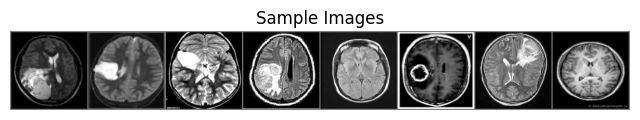

Labels: ['yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no']


In [12]:
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Sample Images")
    plt.axis('off')
    plt.show()

# Get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
print("Labels:", [raw_dataset.classes[l] for l in labels[:8]])

In [16]:
# plt.figure(figsize=(8, 5))
# plt.plot(train_loss_list, label="Train Loss", marker='o')
# plt.plot(val_loss_list, label="Val Loss", marker='s')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Model Loss Over Epochs")
# plt.legend()
# plt.grid(True)
# plt.show()

Save Model

In [15]:
torch.save(model.state_dict(), "brain_tumor_cnn_model.pth")
print("Model saved!")

Model saved!


Prepare a Test DataLoader

In [23]:
test_dir = "D:\\YOLO Comparision\\BrainTumor_CNN\\test"
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

Evaluate Model on Test Set

In [24]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 100.00%


Predict on a Single Image

In [27]:
from PIL import Image

# Load image
image_path = "D:\YOLO Comparision\BrainTumor_CNN\F3.large.jpg"  # update path
img = Image.open(image_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_tensor)
    prediction = torch.argmax(output, dim=1).item()

print("Prediction:", raw_dataset.classes[prediction])

Prediction: yes


<>:4: SyntaxWarning: invalid escape sequence '\Y'
<>:4: SyntaxWarning: invalid escape sequence '\Y'
C:\Users\krish\AppData\Local\Temp\ipykernel_24496\4013881900.py:4: SyntaxWarning: invalid escape sequence '\Y'
  image_path = "D:\YOLO Comparision\BrainTumor_CNN\F3.large.jpg"  # update path
